# Assignment 1


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division
import matplotlib.pyplot as plt

/home/jorge/.local/share/virtualenvs/RecommenderSystems-c5N1t04d/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [3]:
# create inverted index to help recover the words from indexes
inverted_index = {}
for word, i in tokenizer.word_index.items():
    inverted_index[i] = word
    
#print(inverted_index)

### Word-word co-ocurrence matrix and normalization

In [90]:
#create co-occurrence matrix
#print(corpus[0])
coMatrix = np.zeros((V, V))
total = 0
for sequence in corpus:
    for idx, termId in enumerate(sequence):
        sl = len(sequence)
        ## select left window
        leftw = sequence[max(idx - window_size_corpus, 0): idx]
        ## select right window
        rightw = sequence[idx + 1: min(idx + window_size_corpus + 1, sl)]
        # update co-occurrence matrix
        neighboors = leftw + rightw
        for neighbor in neighboors:
            coMatrix[termId, neighbor] += 1
            total += 1
        

# matrix normalization over the total number of the frequencies in the matrix
# as recommended in class
(rows, columns) = coMatrix.shape
for rowIdx in range(rows):
    # ignore first row with 0 entries everywhere
    if (rowIdx > 0):
        row = coMatrix[rowIdx]
        #total = row.sum()
        # avoid division by zero in words that have no neighboors
        if total > 0:
            coMatrix[rowIdx] = np.divide(row, total)


In [89]:
print(coMatrix)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.10132159e-03 1.69986593e-03 ... 2.39417736e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69986593e-03 4.30951925e-04 ... 2.39417736e-05
  2.39417736e-05 2.39417736e-05]
 ...
 [0.00000000e+00 2.39417736e-05 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.39417736e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [5]:
#find cosine similarity to Alice, Dinah and Rabbit
aliceIdx = tokenizer.word_index['Alice'.lower()]
dinahIdx = tokenizer.word_index['Dinah'.lower()]
rabbitIdx = tokenizer.word_index['Rabbit'.lower()]

aliceVector = coMatrix[aliceIdx].reshape(1, -1)
dinahVector = coMatrix[dinahIdx].reshape(1, -1)
rabbitVector = coMatrix[rabbitIdx].reshape(1, -1)
print(aliceVector)
print(dinahVector)
print(rabbitVector)

cosAD = cosine_similarity(aliceVector, dinahVector)
print("Cosine similarity between Alice and Dinah: {}".format(cosAD))
cosAR = cosine_similarity(aliceVector, rabbitVector)
print("Cosine similarity between Alice and Rabbit: {}".format(cosAR))
cosDR = cosine_similarity(dinahVector, rabbitVector)
print("Cosine similarity between Dinah and Rabbit: {}".format(cosDR))


[[0.         0.02646503 0.03402647 ... 0.         0.         0.        ]]
[[0.         0.03448276 0.03448276 ... 0.         0.         0.        ]]
[[0.         0.13559322 0.00847458 ... 0.         0.         0.        ]]
Cosine similarity between Alice and Dinah: [[0.39360011]]
Cosine similarity between Alice and Rabbit: [[0.47890931]]
Cosine similarity between Dinah and Rabbit: [[0.29862324]]


### Five closest words to Alice

In [7]:
#find the closest words to Alice
nbrs = nn(n_neighbors=6, algorithm='brute', metric='cosine').fit(coMatrix)
distances, indices = nbrs.kneighbors(aliceVector)

print("Closest words to Alice")
for pos, index in enumerate(indices[0]):
    print("{}: {}".format(pos, inverted_index[index]))

Closest words to Alice
0: alice
1: she
2: it
3: the
4: a
5: herself


From the results above we observe the six closest words to 'Alice'.

* The first word corresponds to 'Alice' itself. This word is returned by the NearestNeighbors classifier from sklearn by default. 

* The next five words are the closest words to 'Alice'.

In [12]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = []
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(coMatrix[i,:]))))
    f.write("\n")
f.close()

In [27]:
#reopen your file as follows

#co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

### Discussion of the drawbacks: 

The main drawback of the co-occurrence matrix it's its size. It has a size of |V| x |V|, where |V| corresponds to the number of different words in the computed vocabulary (after preprocessing operations like stopwords removal, stemming, etc are applied to the raw texts). For the Alice dataset use in this assigment, the size of |V| is 1182, and the obtained co-ocurrence matrix needs 6mb to be stored. The size of our vocabulary is very small in comparison with other vocabularies used in real world applications. Those vocabularies have tens of thousand, hundreds of thousand, or millions different words, which corresponds to a huge amount of memory needed to store such a big co-occurrence matrix.

Also, this matrix is very sparse, most of its entries contain zeros because most of words in the vocabulary are not associated to the rest of the words. Hence, another representation could be used to avoid using memory to represent non existent associations between words.

By construction, this matrix allows frequent words to be represented by more populated vectors. Therefore, when computing the 'n' most similar words for each vector, these words are more likely to appear in the results than the non frequent words. This becomes a problem when these type of words don't present meaningful information for the final user, like when these words can be considered as stopwords. Weighting techniques like PPMI and tf-idf can be applied to the co-occurrence matrix to solve this issue. 

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [3]:
#prepare data for cbow


In [242]:
#create CBOW model


In [243]:
#define loss function


In [1]:
#train model


In [13]:
#prepare data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
            
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # repeat the same word several times
                    in_words.append([word])
                    # add the context words
                    labels.append(words[i])
            if in_words != []:
                #print(in_words)
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
                #print(all_in)
                #print(all_in[0].shape)
                #print(all_out)
                #print(all_out[0].shape)
                #break
    return (all_in,all_out)

In [14]:
#save the preprocessed data of Skipgram
def save_skipgram_data(filename, x, y):
    f = open(filename ,'w')
    for input,outcome  in zip(x,y):
        input = np.concatenate(input)
        f.write(" ".join(map(str, list(input))))
        f.write(",")
        outcome = np.concatenate(outcome)
        f.write(" ".join(map(str,list(outcome))))
        f.write("\n")
    f.close()

In [15]:
#load the preprocessed Skipgram data
def generate_data_skipgram_from_file(filename):
    f = open(filename ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [16]:
# Generate and save data for skipgram model
DATA_SKIPGRAM_FILENAME = "data_skipgram.txt"
x,y = generate_data_skipgram(corpus,window_size,V)
save_skipgram_data(DATA_SKIPGRAM_FILENAME, x, y)


In [17]:
#create Skipgram models
skipgram_50neurons_model = Sequential()
skipgram_50neurons_model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50neurons_model.add(Reshape((dim, )))
skipgram_50neurons_model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_150neurons_model = Sequential()
skipgram_150neurons_model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150neurons_model.add(Reshape((dim, )))
skipgram_150neurons_model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_300neurons_model = Sequential()
skipgram_300neurons_model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300neurons_model.add(Reshape((dim, )))
skipgram_300neurons_model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [18]:
#define loss function for Skipgrams
skipgram_50neurons_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_150neurons_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_300neurons_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [19]:
#train Skipgram models
EPOCHS = 10

skipgram_50neurons_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_50neurons_model.train_on_batch(x, y)
    skipgram_50neurons_losses.append((ite, loss))
    print("skipgram 50neurons losses: {} -> {}".format(ite, loss))


skipgram_150neurons_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_150neurons_model.train_on_batch(x, y)
    skipgram_150neurons_losses.append((ite, loss))
    print("skipgram 150neurons losses: {} -> {}".format(ite, loss))

skipgram_300neurons_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_300neurons_model.train_on_batch(x, y)
    skipgram_300neurons_losses.append((ite, loss))
    print("skipgram 300neurons losses: {} -> {}".format(ite, loss))


skipgram 50neurons losses: 0 -> 41073.18303287029
skipgram 50neurons losses: 1 -> 36826.03435766697
skipgram 50neurons losses: 2 -> 35294.85650920868
skipgram 50neurons losses: 3 -> 33950.189958930016
skipgram 50neurons losses: 4 -> 32746.543290376663
skipgram 50neurons losses: 5 -> 31693.70681619644
skipgram 50neurons losses: 6 -> 30794.44118589163
skipgram 50neurons losses: 7 -> 30038.335971713066
skipgram 50neurons losses: 8 -> 29411.609778940678
skipgram 50neurons losses: 9 -> 28897.077531903982
skipgram 150neurons losses: 0 -> 41059.224187254906
skipgram 150neurons losses: 1 -> 36788.31235432625
skipgram 150neurons losses: 2 -> 35254.35829436779
skipgram 150neurons losses: 3 -> 33901.64343214035
skipgram 150neurons losses: 4 -> 32700.596487402916
skipgram 150neurons losses: 5 -> 31647.698303699493
skipgram 150neurons losses: 6 -> 30743.04159939289
skipgram 150neurons losses: 7 -> 29980.76098102331
skipgram 150neurons losses: 8 -> 29348.937805831432
skipgram 150neurons losses: 9 ->

In [20]:
# save computed vectors
def save_computed_vectors(filename, vectors):
    f = open(filename ,'w')
    f.write(" ".join([str(V-1),str(dim)]))
    f.write("\n")

    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()

In [21]:
#Save computed vectors
VECTORS_SKIPGRAM_50NEURONS_FILENAME = 'vectors_skipgram_50neurons.txt'
skipgram_50neurons_model_vectors = skipgram_50neurons_model.get_weights()[0]
save_computed_vectors(VECTORS_SKIPGRAM_50NEURONS_FILENAME, skipgram_50neurons_model_vectors)

VECTORS_SKIPGRAM_150NEURONS_FILENAME = 'vectors_skipgram_150neurons.txt'
skipgram_150neurons_model_vectors = skipgram_150neurons_model.get_weights()[0]
save_computed_vectors(VECTORS_SKIPGRAM_150NEURONS_FILENAME, skipgram_150neurons_model_vectors)

VECTORS_SKIPGRAM_300NEURONS_FILENAME = 'vectors_skipgram_300neurons.txt'
skipgram_300neurons_model_vectors = skipgram_300neurons_model.get_weights()[0]
save_computed_vectors(VECTORS_SKIPGRAM_300NEURONS_FILENAME, skipgram_300neurons_model_vectors)

In [22]:
# load computed vectors
def load_word_vectors(filename):
    f = open(filename, 'r')
    # read first line to get the dimensions
    dim_rows = 0
    dim_columns = 0
    word_vectors = None
    for line in f.readlines():
        input_values = line.strip().split(" ")
        if len(input_values) == 2:
            dim_rows = int(input_values[0])
            dim_columns = int(input_values[1])
            word_vectors = np.zeros((dim_rows+1, dim_columns))
            #print("rows: {}, columns: {}".format(dim_rows, dim_columns))
        else:
            word = input_values[0]
            vector_values = np.fromstring(" ".join(input_values[1:]), dtype=float, sep=' ')
            word_vectors[tokenizer.word_index[word]] = vector_values
            
    f.close()
    return word_vectors


In [23]:
loaded_skipgram_50neurons_model_vectors = load_word_vectors(VECTORS_SKIPGRAM_50NEURONS_FILENAME)
loaded_skipgram_150neurons_model_vectors = load_word_vectors(VECTORS_SKIPGRAM_150NEURONS_FILENAME)
loaded_skipgram_300neurons_model_vectors = load_word_vectors(VECTORS_SKIPGRAM_300NEURONS_FILENAME)

In [ ]:
#create CBOW model with additional dense layer


In [ ]:
#define loss function for CBOW + dense


In [ ]:
#train model for CBOW + dense


In [24]:
#create Skipgram models with additional dense layer
skipgram_50neurons_modified_model = Sequential()
skipgram_50neurons_modified_model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50neurons_modified_model.add(Reshape((dim, )))
skipgram_50neurons_modified_model.add(Dense(input_dim=dim, units=dim, kernel_initializer='he_uniform', activation='relu'))
skipgram_50neurons_modified_model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

skipgram_150neurons_modified_model = Sequential()
skipgram_150neurons_modified_model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150neurons_modified_model.add(Reshape((dim, )))
skipgram_150neurons_modified_model.add(Dense(input_dim=dim, units=dim, kernel_initializer='he_uniform', activation='relu'))
skipgram_150neurons_modified_model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))


skipgram_300neurons_modified_model = Sequential()
skipgram_300neurons_modified_model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300neurons_modified_model.add(Reshape((dim, )))
skipgram_300neurons_modified_model.add(Dense(input_dim=dim, units=dim, kernel_initializer='he_uniform', activation='relu'))
skipgram_300neurons_modified_model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [25]:
#define loss function for Skipgram + dense
skipgram_50neurons_modified_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_150neurons_modified_model.compile(loss='categorical_crossentropy', optimizer='adam')
skipgram_300neurons_modified_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [26]:
#train model for Skipgram + dense
EPOCHS = 10

skipgram_50neurons_modified_model_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_50neurons_modified_model.train_on_batch(x, y)
    skipgram_50neurons_modified_model_losses.append((ite, loss))
    print("skipgram 50neurons modified losses: {} -> {}".format(ite, loss))


skipgram_150neurons_modified_model_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_150neurons_modified_model.train_on_batch(x, y)
    skipgram_150neurons_modified_model_losses.append((ite, loss))
    print("skipgram 150neurons modified losses: {} -> {}".format(ite, loss))

skipgram_300neurons_modified_model_losses = []
for ite in range(EPOCHS):
    loss = 0.
    for x, y in generate_data_skipgram_from_file(DATA_SKIPGRAM_FILENAME):
        loss += skipgram_300neurons_modified_model.train_on_batch(x, y)
    skipgram_300neurons_modified_model_losses.append((ite, loss))
    print("skipgram 300neurons modified losses: {} -> {}".format(ite, loss))


skipgram 50neurons modified losses: 0 -> 40317.54647278786
skipgram 50neurons modified losses: 1 -> 36746.74798989296
skipgram 50neurons modified losses: 2 -> 35182.12660086155
skipgram 50neurons modified losses: 3 -> 33688.58572089672
skipgram 50neurons modified losses: 4 -> 32583.715933918953
skipgram 50neurons modified losses: 5 -> 31683.261390149593
skipgram 50neurons modified losses: 6 -> 31011.452765107155
skipgram 50neurons modified losses: 7 -> 30557.971965312958
skipgram 50neurons modified losses: 8 -> 30165.50262606144
skipgram 50neurons modified losses: 9 -> 29802.00397466123
skipgram 150neurons modified losses: 0 -> 40335.78914117813
skipgram 150neurons modified losses: 1 -> 36769.79259300232
skipgram 150neurons modified losses: 2 -> 35205.47082412243
skipgram 150neurons modified losses: 3 -> 33837.447959423065
skipgram 150neurons modified losses: 4 -> 32771.934980392456
skipgram 150neurons modified losses: 5 -> 31891.153545081615
skipgram 150neurons modified losses: 6 -> 3

In [29]:
#Save computed vectors
VECTORS_SKIPGRAM_50NEURONS_MODIFIED_FILENAME = 'vectors_skipgram_50neurons_modified.txt'
skipgram_50neurons_modified_model_vectors = skipgram_50neurons_modified_model.get_weights()[0]
save_computed_vectors(VECTORS_SKIPGRAM_50NEURONS_MODIFIED_FILENAME, skipgram_50neurons_modified_model_vectors)

VECTORS_SKIPGRAM_150NEURONS_MODIFIED_FILENAME = 'vectors_skipgram_150neurons_modified.txt'
skipgram_150neurons_modified_model_vectors = skipgram_150neurons_modified_model.get_weights()[0]
save_computed_vectors(VECTORS_SKIPGRAM_150NEURONS_MODIFIED_FILENAME, skipgram_150neurons_modified_model_vectors)

VECTORS_SKIPGRAM_300NEURONS_MODIFIED_FILENAME = 'vectors_skipgram_300neurons_modified.txt'
skipgram_300neurons_modified_model_vectors = skipgram_300neurons_modified_model.get_weights()[0]
save_computed_vectors(VECTORS_SKIPGRAM_300NEURONS_MODIFIED_FILENAME, skipgram_300neurons_modified_model_vectors)

In [30]:
## train nearest neighbors model
nn_skipgram_50neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_50neurons_model_vectors)
nn_skipgram_50neurons_modified = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_50neurons_modified_model_vectors)

nn_skipgram_150neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_150neurons_model_vectors)
nn_skipgram_150neurons_modified = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_150neurons_modified_model_vectors)

nn_skipgram_300neurons = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_300neurons_model_vectors)
nn_skipgram_300neurons_modified = nn(n_neighbors=21, algorithm='brute', metric='cosine').fit(skipgram_300neurons_modified_model_vectors)


In [31]:
ds, indices_skipgram_50neurons = nn_skipgram_50neurons.kneighbors(skipgram_50neurons_model_vectors)
ds, indices_skipgram_50neurons_modified = nn_skipgram_50neurons_modified.kneighbors(skipgram_50neurons_modified_model_vectors)

ds, indices_skipgram_150neurons = nn_skipgram_150neurons.kneighbors(skipgram_150neurons_model_vectors)
ds, indices_skipgram_150neurons_modified = nn_skipgram_150neurons_modified.kneighbors(skipgram_150neurons_modified_model_vectors)

ds, indices_skipgram_300neurons = nn_skipgram_300neurons.kneighbors(skipgram_300neurons_model_vectors)
ds, indices_skipgram_300neurons_modified = nn_skipgram_300neurons_modified.kneighbors(skipgram_300neurons_modified_model_vectors)

In [32]:
def save_neighbors(filename, neighbors):
    f = open(filename, 'w')
    
    for idrow, matrix_row in enumerate(neighbors):
        words = []
        if idrow > 0:
            for idc, column in enumerate(matrix_row):
                if column > 0 :
                    words.append(inverted_index[column])
            f.write(", ".join(words))
            f.write("\n")
    f.close()
            

In [33]:
SKIPGRAM_50NEURONS_NN_FILENAME = "skipgram_50neurons_nn.txt"
SKIPGRAM_50NEURONS_MODIFIED_NN_FILENAME = "skipgram_50neurons_modified_nn.txt"
SKIPGRAM_150NEURONS_NN_FILENAME = "skipgram_50neurons_nn.txt"
SKIPGRAM_150NEURONS_MODIFIED_NN_FILENAME = "skipgram_150neurons_modified_nn.txt"
SKIPGRAM_300NEURONS_NN_FILENAME = "skipgram_300neurons_nn.txt"
SKIPGRAM_300NEURONS_MODIFIED_NN_FILENAME = "skipgram_300neurons_modified_nn.txt"

save_neighbors(SKIPGRAM_50NEURONS_NN_FILENAME, indices_skipgram_50neurons)
save_neighbors(SKIPGRAM_50NEURONS_MODIFIED_NN_FILENAME, indices_skipgram_50neurons_modified)

save_neighbors(SKIPGRAM_150NEURONS_NN_FILENAME, indices_skipgram_150neurons)
save_neighbors(SKIPGRAM_150NEURONS_MODIFIED_NN_FILENAME, indices_skipgram_150neurons_modified)

save_neighbors(SKIPGRAM_300NEURONS_NN_FILENAME, indices_skipgram_300neurons)
save_neighbors(SKIPGRAM_300NEURONS_MODIFIED_NN_FILENAME, indices_skipgram_300neurons_modified)

### Analogy function

Due to the small dataset (Alice.txt) used for this assignment, we decided to implement a modified version of the analogy function explained in [insert reference here]. First, our function computes an aggregated vector from the first three words in a given analogy. Then, we find the top 20 nearest neighbors for this vector using the corresponding word embeddings (skipgram or CBOW models) and nearest neighbors models. Finally, if the target word (fourth word) is contained in the top 20 nearestest neighbors, we return a True value as an indication of a valid analogy. 

In [53]:
#Implement your own analogy function
# implementation of the function argmax(w.(w3 + w2 - w1)), with w - w3 =' w2 - w1
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.neighbors import NearestNeighbors as nn
#nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)

# computes: word1 is a word2 as word3 is to target
# returns true if target is found in the closest 10 neighbors
def is_valid_analogy(word1, word2, word3, target, word_vectors, nnmodel):
    if word1 not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(word1))
        return False
    if word2 not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(word2))
        return False
    if word3 not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(word3))
        return False
    if target not in tokenizer.word_index:
        print("Word {} not in tokenizer.word_index".format(target))
        return False
    
    vector_w1 = word_vectors[tokenizer.word_index[word1]]
    vector_w2 = word_vectors[tokenizer.word_index[word2]]
    vector_w3 = word_vectors[tokenizer.word_index[word3]]
    composed_vector = vector_w1 - vector_w2 + vector_w3
    distances, indices = nnmodel.kneighbors(composed_vector.reshape(1, -1))
    return tokenizer.word_index[target] in indices

def analogy_precision(analogies, word_vectors, nnmodel):
    correct = 0
    total = 0
    for analogy in analogies:
        #print(analogy)
        if is_valid_analogy(analogy[0], analogy[1], analogy[2], analogy[3], word_vectors, nnmodel):
            correct += 1
        total += 1
    return correct/(total*1.0)




## Analyze the four different word embeddings

To analyze the word embeddings we use analogies. The previously defined analogy function is used to computed the precision of word embeddings on the analogy data. The results are shown below.


In [72]:
analogy_data = ["sudden suddenly usual usually",
"bad worse good better",
"go going look looking",
"he she his her",
"brother sister his her",
"listen listening look looking",
"saying said thinking thought",
"bird birds cat cats",
"good better old older",
"good better quick quicker",
"large largest good best",
"falling fell knowing knew",
"walk walking think thinking",
"child children cat cats",
"dog dogs eye eyes",
"hand hands rat rats",
"eat eats find finds",
"find finds say says",
"old older good better",
"large larger quick quicker",
"go going listen listening",
"run running walk walking",
"run running think thinking",
"say saying sit sitting",
"alice she rabbit he",
"alice her rabbit him",
"alice girl rabbit sir",
"dinah cat alice girl",
"his her he she",
"long longer quick quicker",
"long longer small smaller",
"long longer bad worse",
"go going look looking",
"listen listening look looking",
"swim swimming sit sitting",
"run running listen listening",
"think thinking read reading",
"up down close far",
"rome paris neck legs",
"tears smiling smaller larger",
"rome paris apple cherry",
"child children dog dogs",
"young energetic old tired"]

In [77]:
#prepare analogies

analogies = []
for row in analogy_data:
        #print(row)
        analogy = row.split(" ")
        if len(analogy) == 4:
            #print(analogy)
            analogies.append(analogy)

In [78]:
# Testing skipgram models with analogies
analogies_results = {}
analogies_results["skip_50n"] = analogy_precision(analogies, skipgram_50neurons_model_vectors,
                                                 nn_skipgram_50neurons)

analogies_results["skip_150n"] = analogy_precision(analogies, skipgram_150neurons_model_vectors,
                                                 nn_skipgram_150neurons)
analogies_results["skip_300n"] = analogy_precision(analogies, skipgram_300neurons_model_vectors,
                                                 nn_skipgram_300neurons)
analogies_results["skip_50n_mod"] = analogy_precision(analogies, skipgram_50neurons_modified_model_vectors,
                                                 nn_skipgram_50neurons_modified)
analogies_results["skip_150n_mod"] = analogy_precision(analogies, skipgram_150neurons_modified_model_vectors,
                                                 nn_skipgram_150neurons_modified)
analogies_results["skip_300n_mod"] = analogy_precision(analogies, skipgram_300neurons_modified_model_vectors,
                                                 nn_skipgram_300neurons_modified)



### Results of skipgram models on analogies


In [79]:
print("Precision for word vectors of 50x1 using skipgram model: {:3f}".format(analogies_results["skip_50n"]))
print("Precision for word vectors of 150x1 using skipgram model: {:3f}".format(analogies_results["skip_150n"]))
print("Precision for word vectors of 300x1 using skipgram model: {:3f}".format(analogies_results["skip_300n"]))

print("Precision for word vectors of 50x1 using modified skipgram model: {:3f}".format(analogies_results["skip_50n_mod"]))
print("Precision for word vectors of 150x1 using modified skipgram model: {:3f}".format(analogies_results["skip_150n_mod"]))
print("Precision for word vectors of 300x1 using modified skipgram model: {:3f}".format(analogies_results["skip_300n_mod"]))


Precision for word vectors of 50x1 using skipgram model: 0.093023
Precision for word vectors of 150x1 using skipgram model: 0.069767
Precision for word vectors of 300x1 using skipgram model: 0.093023
Precision for word vectors of 50x1 using modified skipgram model: 0.000000
Precision for word vectors of 150x1 using modified skipgram model: 0.023256
Precision for word vectors of 300x1 using modified skipgram model: 0.000000


### Comparison performance:


### Visualization and interpretation of results

#### Visualization of Skipgram models

The next two figures show the TSNE representation of some of the words used in the analogy task for two skipgram models:
    * skipgram model with 300 neurons in the representation layer
    * modified skipgram model with 300 neurons in the representation layer
    
 These two models correspond to the best and worst skipgram models according to the analogy task.

In [83]:
analogy_words_to_visualize = ['bad', 'worse', 'good', 'better',
                            'listen', 'listening', 'look', 'looking',
                            'bird', 'birds', 'cat', 'cats',
                            'good', 'better', 'old', 'older',
                            'dog', 'dogs', 'eye', 'eyes',
                            'hand', 'hands', 'rat', 'rats',
                            'run', 'running', 'walk', 'walking',
                            'young', 'energetic', 'old', 'tired']


In [84]:
# skipgram model with 300 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
skipgram_300neurons_model_vectors_projection = tsne.fit_transform(skipgram_300neurons_model_vectors).T
print("skipgram 300 neurons vectors projection computed")

# skipgram model with 300 neurons
tsne = TSNE(n_components=2, init='pca', random_state=0)
skipgram_300neurons_modified_model_vectors_projection = tsne.fit_transform(skipgram_300neurons_modified_model_vectors).T
print("skipgram 300 neurons modified model vectors projection computed")


skipgram 300 neurons vectors projection computed
skipgram 300 neurons modified model vectors projection computed


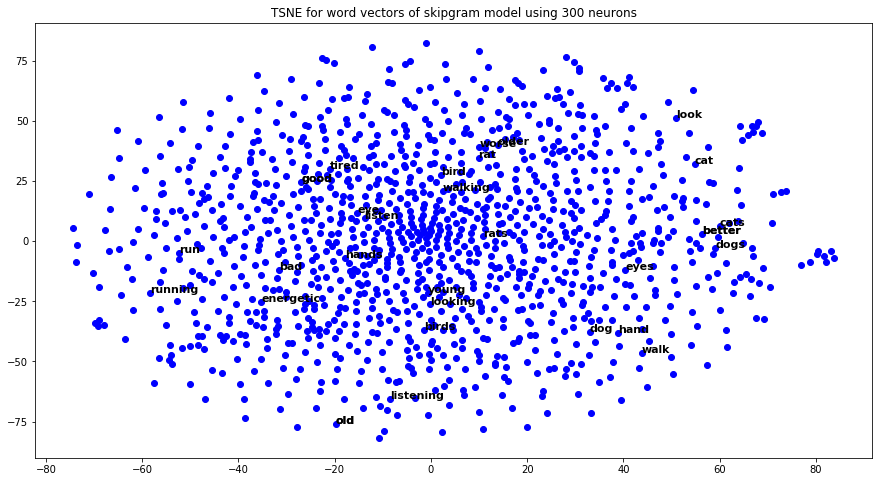

In [86]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(skipgram_300neurons_model_vectors_projection[0],
            skipgram_300neurons_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= skipgram_300neurons_model_vectors_projection[0][idx]
    y_pos= skipgram_300neurons_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of skipgram model using 300 neurons")
plt.show()

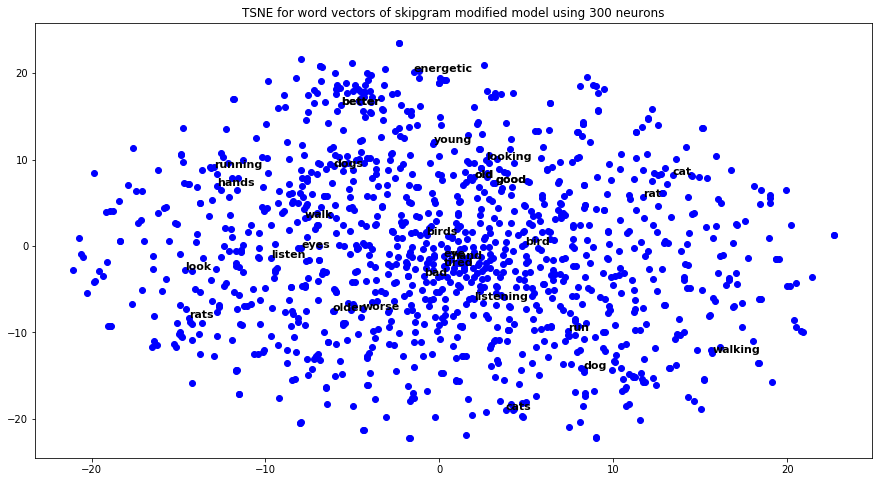

In [87]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(skipgram_300neurons_modified_model_vectors_projection[0],
            skipgram_300neurons_modified_model_vectors_projection[1],
            c='b', cmap=plt.cm.Spectral)

for word in analogy_words_to_visualize:
    idx = tokenizer.word_index[word]
    x_pos= skipgram_300neurons_modified_model_vectors_projection[0][idx]
    y_pos= skipgram_300neurons_modified_model_vectors_projection[1][idx]
    plt.annotate(word, (x_pos, y_pos), fontsize=11, fontweight='bold')

plt.title("TSNE for word vectors of skipgram modified model using 300 neurons")
plt.show()

### Interpretation results of the visualization

#### Visualizations for Skipgram models

#### Visualizations for CBOW models

## 2.5 Using the word-word co-occurrence matrix from question 1. Compare the results of the trained word embeddings with the word-word co-occurrence matrix

## 2.6 Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

In [ ]:
#load pretrained word embeddings of word2vec

path_word2vec = "your path /GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
#load pretraind word embeddings of Glove

path = "your path /glove.6B/glove.6B.300d_converted.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [ ]:
#Visualize the pre-trained word embeddings

Comparison performance with your own trained word embeddings